In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy, scipy as sklearn, librosa, urllib
import librosa.display
from IPython.display import Audio
import json 
import seaborn as sns
from sklearn.cluster import KMeans
import csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
import keras
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from os import path

from itertools import cycle
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc, silhouette_score,roc_auc_score, precision_recall_fscore_support
from tqdm import tqdm
import opensmile


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

from tensorflow.keras import regularizers
from joblib import dump, load

from tensorflow.keras.datasets import mnist


In [2]:
def get_emo_df(emotion, dataframe):
    emo = []
    tot = 0
    print(f"Processing {emotion} ...")
    for id, name in zip(dataframe["filename"],dataframe["label"]):
        if f"{emotion}" in name:
            emo.append(id)
            tot += 1
    print(f"Processed {tot} file for {emotion}")


    mask = dataframe['filename'].isin(emo)
    emo_df = dataframe[mask].reset_index()
    emo_df = emo_df.drop(['index'], axis=1)
    return emo_df


In [5]:
clear_df = pd.read_pickle("clear_functional.pkl")
# clear_df = pd.read_pickle("clear_functional_emovo.pkl")

# clear_df = pd.read_pickle("pitch_functional_demos.pkl")
# clear_df = pd.read_pickle("pitch_functional_emovo.pkl")

In [6]:
labels = clear_df["label"].unique()
labels

array(['neutral', 'guilt', 'disgust', 'happiness', 'fear', 'anger',
       'surprise', 'sadness'], dtype=object)

In [7]:
df = []

for i,emotion in enumerate(labels):
    df.append(get_emo_df(emotion,clear_df))

Processing neutral ...
Processed 332 file for neutral
Processing guilt ...
Processed 1129 file for guilt
Processing disgust ...
Processed 1678 file for disgust
Processing happiness ...
Processed 1395 file for happiness
Processing fear ...
Processed 1156 file for fear
Processing anger ...
Processed 1477 file for anger
Processing surprise ...
Processed 1000 file for surprise
Processing sadness ...
Processed 1529 file for sadness


In [8]:
def get_data(df):
    X = pd.concat(df["features"].tolist(), ignore_index=True)
    _X= (X-X.min())/(X.max()-X.min())


    X_train, X_test = train_test_split(_X, test_size=.2, random_state=22)
    X_train, X_val = train_test_split(X_train, test_size=.1, random_state=22)
    # print(len(X_train), len(X_val), len(X_test))
    return X_train, X_val, X_test

In [9]:
train = []
val = []
test = []
for data in df:
    tr, v, te = get_data(data)
    train.append(tr)
    val.append(v)
    test.append(te)

In [10]:
def get_rec_error(ae):
    errors = {}
    for i in labels:
        errors[i] = None
    for i in range(len(labels)):
        data = df[i]
        _X_train, _X_val, _X_test = get_data(data)
        reconstructed_X = ae.predict(_X_test)
        mse_per_feature = ((_X_test - reconstructed_X)**2).mean(axis=0)
        errors[labels[i]] = np.mean(mse_per_feature)
    return errors
        

In [11]:
def build_autoencoder(neurons_in=64, act_function="sigmoid", optimizer="adam", hidden_layers=0):
    
    input_l = Input(shape=(88,),name='input_l')

    encoded_l1 = Dense(neurons_in*4, activation='relu', name='encoded_1')(input_l) 
    encoded_l2 = Dense(neurons_in*2, activation='relu', name='encoded_2')(encoded_l1)
    # encoded_l3 = Dense(20, activation='relu', name='encoded_3')(encoded_l2)

    bottleneck = Dense(neurons_in, activation='relu', name='bottleneck')(encoded_l2)

    # decoded_l1 = Dense(20, activation='relu', name='decoded_3')(bottleneck)
    decoded_l2 = Dense(neurons_in*2, activation='relu', name='decoded_4')(bottleneck)
    decoded_l3 = Dense(neurons_in*4, activation='relu', name='decoded_5')(decoded_l2)

    output_l = Dense(88, activation=act_function, name='output_l')(decoded_l3)


    # error = 1 - (input_l - output_l)

    

    # mse =  tf.reduce_mean(tf.square(input_l - output_l))
    # mse = tf.reshape(mse, (-1, 1))


    ac = Model(input_l,output_l )
    ac.compile(loss="binary_crossentropy", optimizer=optimizer)
    
    return ac

In [12]:
import tensorflow as tf
# Loss personalizzata
def custom_loss(y_true, y_pred,):
    
    class_labels = y_true[:, -1]        
    original_data = y_true[:, :-1]      

    return contrastive_loss(original_data, y_pred, class_labels, alpha=1)
def contrastive_loss(y_true, y_pred, class_labels, alpha):
    """
    Funzione di loss contrastiva che:
    - Minimizza l'errore di ricostruzione per la classe target (class_labels = 1).
    - Massimizza l'errore di ricostruzione per le altre classi (class_labels = 0).
    """
   
    reconstruction_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    
    
    target_loss = class_labels * tf.square(reconstruction_loss)
    
   
    non_target_loss = (1.0 - class_labels) * tf.square(tf.maximum(alpha - reconstruction_loss, 0.0))
    
    
    loss_tot = target_loss + non_target_loss
    return tf.reduce_mean(loss_tot)


In [13]:
def build_autoencoder(neurons_in=64, act_function="sigmoid", optimizer="adam", hidden_layers=0):
    model = keras.Sequential()
    model.add(Input(shape= (88,)))


    for i in range(hidden_layers):
        model.add(Dense(neurons_in*(2*(i+1)), activation='relu'))
    

    # encoded_l1 = Dense(neurons_in*4, activation='relu', name='encoded_1')(input_l) 
    # encoded_l2 = Dense(neurons_in*2, activation='relu', name='encoded_2')(input_l)
    # encoded_l3 = Dense(20, activation='relu', name='encoded_3')(encoded_l2)

    model.add(Dense(neurons_in, activation='relu', name='bottleneck'))

    # decoded_l1 = Dense(20, activation='relu', name='decoded_3')(bottleneck)
    # decoded_l2 = Dense(neurons_in*2, activation='relu', name='decoded_4')(bottleneck)
    # decoded_l3 = Dense(neurons_in*4, activation='relu', name='decoded_5')(decoded_l2)

    for i in range(hidden_layers):
        model.add(Dense(neurons_in*(2*(i+1)), activation='relu'))
    # Dense(88, activation=act_function, name='output_l')(decoded_l3)
    model.add(Dense(88, activation=act_function, name='decoded'))
    # ac = Model(input_l,output_l)
    

    model.compile(loss="binary_crossentropy", optimizer=optimizer)
    
    return model

In [14]:
from datetime import datetime  
def train_autoencoder(emotion,data_t,data_v, index):
    name = datetime.now().strftime(f"model/autoencoders/ae_{emotion}_%d_%m_%Y_%H_%M_%S.keras")
    print(f"training on {emotion}")
    print(f"Model name : {name}")
    ae = build_autoencoder(64,"sigmoid","adam",0)
    callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = name,
        save_best_only=True,
        verbose=0,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(  
        monitor="val_loss",
        min_delta=0.001,
        patience=40,
        verbose=0,
        mode="auto",
        restore_best_weights=True
    )
    ]

    _X_train = data_t[index].to_numpy()
    _X_val = data_v[index].to_numpy()


    # y_train = np.hstack([_X_train,np.ones((_X_train.shape[0],1))])
    # y_val = np.hstack([_X_val,np.ones((_X_val.shape[0],1))])

    history = ae.fit(_X_train,_X_train,
                validation_data = (_X_val,_X_val),
                epochs=5000,
                batch_size=128,
                verbose=0,
                callbacks = callbacks)
    print(history.history['val_loss'][-1])
    # print(history.history["epoch"][-1])
    return ae

In [17]:
#  {'act_function': 'sigmoid', 'hidden_layers': 0, 'neurons_in': 64, 'optimizer': 'Adam'}

In [20]:
autoencoders = []
for i,emotion in enumerate(labels):
    # autoencoders.append(train_autoencoder(emotion, df[i], i))
    autoencoders.append(train_autoencoder(emotion, train, val, i))

training on disgust
Model name : model/autoencoders/ae_disgust_14_11_2024_12_15_13.keras
0.5504766702651978
training on joy
Model name : model/autoencoders/ae_joy_14_11_2024_12_15_35.keras
0.5343595743179321
training on neutrality
Model name : model/autoencoders/ae_neutrality_14_11_2024_12_16_04.keras
0.5296974778175354
training on fear
Model name : model/autoencoders/ae_fear_14_11_2024_12_16_28.keras
0.5287033915519714
training on anger
Model name : model/autoencoders/ae_anger_14_11_2024_12_16_56.keras
0.5346786379814148
training on surprise
Model name : model/autoencoders/ae_surprise_14_11_2024_12_17_15.keras
0.5405970215797424
training on sadness
Model name : model/autoencoders/ae_sadness_14_11_2024_12_17_50.keras
0.522896945476532


In [22]:
from collections import Counter

class MyVotingClassifier:
    def __init__(self, **models):
        self.models = models
    
    def predict(dict_X):
        '''
        dict_X = {'knn_model_1': X1, 'knn_model_2': X2, 'knn_model_3': X3}
        '''
        preds = []
        for model_name in dict_X:
            model = self.models[model_name]
            preds.append(model.predict(dict_X[model_name]))
        preds = list(zip(*preds))
        final_pred = list(map(lambda x: Counter(x).most_common(1)[0][0]))
        return final_pred


In [26]:
X_test = test[0].to_numpy()

array([0.93039834, 0.12636746, 0.93721217, 0.8598165 , 0.8589971 ,
       0.10430427, 0.0951716 , 0.09926985, 0.06517773, 0.06136449,
       0.879216  , 0.5035035 , 0.02130546, 0.9391722 , 0.9474388 ,
       0.9734376 , 0.72070134, 0.5959515 , 0.49043998, 0.6238057 ,
       0.7250129 , 0.4460458 , 0.13240291, 0.9109866 , 0.19145863,
       0.59476554, 0.13279699, 0.49016994, 0.35571858, 0.77817714,
       0.01244657, 0.60474604, 0.11122476, 0.90340436, 0.91380674,
       0.03242939, 0.54480696, 0.06999745, 0.01535852, 0.714254  ,
       0.59068847, 0.57892996, 0.53185195, 0.44449762, 0.5225485 ,
       0.5447115 , 0.71778905, 0.4858376 , 0.3586071 , 0.491042  ,
       0.73637366, 0.24692385, 0.58284897, 0.80241925, 0.75658906,
       0.43990147, 0.7540721 , 0.21005048, 0.6374365 , 0.3673901 ,
       0.23452789, 0.66613615, 0.9525645 , 0.57998806, 0.24085654,
       0.08078284, 0.80318224, 0.5422585 , 0.35989794, 0.4799732 ,
       0.24059473, 0.87019163, 0.26317048, 0.16309094, 0.32319

TypeError: TensorFlowTrainer.predict() missing 1 required positional argument: 'x'

In [37]:
dict_errors = {}
for i in labels:
    dict_errors[i] = None
for i in range(len(autoencoders)):
    dict_errors[labels[i]] = get_rec_error(autoencoders[i])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━

<Axes: >

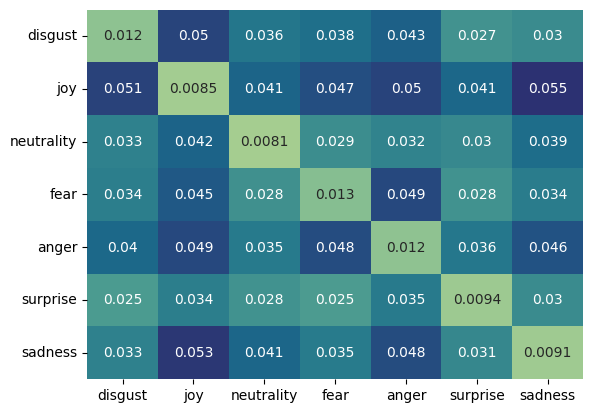

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
table = pd.DataFrame.from_dict(dict_errors, orient='index')
fig = plt.figure(facecolor='w', edgecolor='k')
sns.heatmap(table, annot=True, cmap='crest', cbar=False)
# plt.savefig('DataFrame.png')

In [44]:
def make_prediction(X_test):
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    _er = []
    y_pred = []
    for encoder in autoencoders:
        _er.append(mean_squared_error(X_test,encoder.predict(X_test.reshape(-1,88), verbose=0).reshape(88,)))
    y_pred.append(np.argmin(_er))
    print(y_pred)

In [50]:
make_prediction(X_test[3])

[1]


In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_true = []

y_pred = []
errors = []
_test = []
for n in range(len(test)):
    _test.append(test[n].to_numpy())
for n in range(len(df)):
    X_test = _test[n]
    cls = []

    for i in (range(len(X_test))):
        _er = []
        for encoder in autoencoders:
            #print(labels[x])
            _er.append(mean_squared_error(X_test[i],encoder.predict(X_test[i].reshape(-1,88), verbose=0).reshape(88,)))
        errors.append(_er)
        y_pred.append(np.argmin(_er))
        y_true.append(n)
    #pred.append(cls)
    # print(cls)

Text(0.5, 1.0, 'EMOVO Pitch Augmentation')

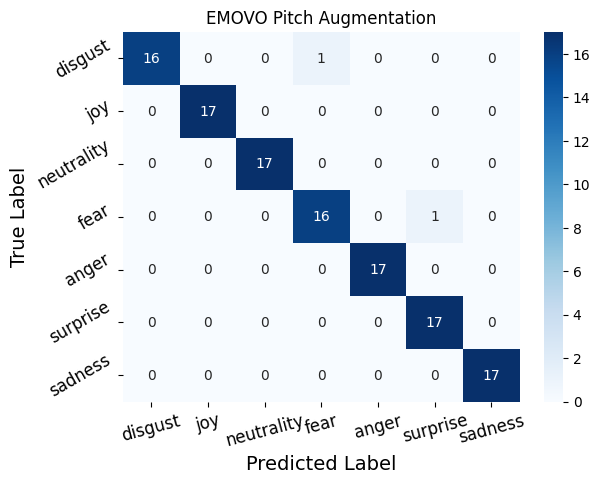

In [52]:
cm = confusion_matrix(y_true,y_pred)

g = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True)
g.xaxis.set_ticklabels(labels, rotation = 15,fontsize=12)
g.yaxis.set_ticklabels(labels, rotation = 30,fontsize=12)
g.set_xlabel("Predicted Label", fontsize=14)
g.set_ylabel("True Label", fontsize = 14)
g.set_title("EMOVO Pitch Augmentation")
# g.figure.savefig("EMOVO_Pitch_Augmentation.png")

# g.set_title(data, fontsize = 18)

In [43]:
from sklearn.metrics import average_precision_score, recall_score, precision_score
score = 1- np.array(errors)
true_lab = y_true
ap = average_precision_score(true_lab, score)
ap

0.9760650218119584

In [23]:
def build_autoencoder(neurons_in=16, act_function="sigmoid", optimizer="adam", hidden_layers=1):
    model = keras.Sequential()
    model.add(Input(shape= (88,)))


    for i in range(hidden_layers):
        model.add(Dense(neurons_in*(2*(i+1)), activation='relu', kernel_regularizer=keras.regularizers.l2(0.1)))
    

    # encoded_l1 = Dense(neurons_in*4, activation='relu', name='encoded_1')(input_l) 
    # encoded_l2 = Dense(neurons_in*2, activation='relu', name='encoded_2')(input_l)
    # encoded_l3 = Dense(20, activation='relu', name='encoded_3')(encoded_l2)

    model.add(Dense(neurons_in, activation='relu', name='bottleneck', kernel_regularizer=keras.regularizers.l2(0.1)))

    # decoded_l1 = Dense(20, activation='relu', name='decoded_3')(bottleneck)
    # decoded_l2 = Dense(neurons_in*2, activation='relu', name='decoded_4')(bottleneck)
    # decoded_l3 = Dense(neurons_in*4, activation='relu', name='decoded_5')(decoded_l2)

    for i in range(hidden_layers):
        model.add(Dense(neurons_in*(2*(i+1)), activation='relu', kernel_regularizer=keras.regularizers.l2(0.1)))
    # Dense(88, activation=act_function, name='output_l')(decoded_l3)
    model.add(Dense(88, activation=act_function, name='output_l'))
    # ac = Model(input_l,output_l)
    
    model.compile(loss="binary_crossentropy", optimizer=optimizer)
    
    return model

In [19]:
from sklearn.metrics import mean_squared_error


def score_func(y, y_pred):
    error = mean_squared_error(y, y_pred)
    return error

from sklearn.metrics import make_scorer
recon_error = make_scorer(score_func, greater_is_better=False)

64

In [24]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV


# param_grid = [{'neurons_in':[2**4,2**3, 2**2], "act_function" : ["sigmoid", "relu", "leaky_relu", 'tanh'], "optimizer" : ['SGD', 'RMSprop', 'Adam', 'Adamax', 'Nadam']}]
neurons_in = [2**4,2**3, 2**2]
act_function = ["sigmoid", "relu", "leaky_relu", 'tanh']
optimizer = ['SGD', 'RMSprop', 'Adam', 'Adamax', 'Nadam']
hidden_layers = [0,1,2]

param_grid = dict(neurons_in = [2**5, 2**4,2**3, 2**2], act_function = ["sigmoid"], optimizer = ['Adam'], hidden_layers = [0,1,2] )
callbacks = [
keras.callbacks.EarlyStopping(  
    monitor="val_loss",
    min_delta=0.001,
    patience=40,
    verbose=0,
    mode="auto",
    restore_best_weights=True
)
]
# , act_function = act_function, optimizer=optimizer

autoencoder_base = KerasRegressor(build_autoencoder, verbose=3, neurons_in = neurons_in, act_function = act_function, optimizer=optimizer, hidden_layers = hidden_layers)
# Esegui la grid search
grid = GridSearchCV(estimator=autoencoder_base, param_grid=param_grid, n_jobs=-1, cv=5, verbose=3, scoring=recon_error)
history = grid.fit(train[0].to_numpy(),train[0].to_numpy(),
                   epochs=1000,
                   batch_size=128, 
                   shuffle=True,
                   validation_data=(val[0].to_numpy(),val[0].to_numpy()),
                   callbacks = callbacks)

gs_results = history.cv_results_


print('\n\n CV results:')

for mean_score, params in zip(gs_results['mean_test_score'],gs_results['params']):
    print(mean_score,params)

best_params = history.best_params_
best_score = history.best_score_

print(f"\n\n The best Hyperparameter combination is:\n {best_params} \n with a mean test score of: {best_score}") 

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Epoch 1/1000
Epoch 2/1000
Epoch 3/1000
Epoch 4/1000
Epoch 5/1000
Epoch 6/1000
Epoch 7/1000
Epoch 8/1000
Epoch 9/1000
Epoch 10/1000
Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000
Epoch 16/1000
Epoch 17/1000
Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000
Epoch 22/1000
Epoch 23/1000
Epoch 24/1000
Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000
Epoch 30/1000
Epoch 31/1000
Epoch 32/1000
Epoch 33/1000
Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000
Epoch 38/1000
Epoch 39/1000
Epoch 40/1000
Epoch 41/1000
Epoch 42/1000
Epoch 43/1000
Epoch 44/1000
Epoch 45/1000
Epoch 46/1000
Epoch 47/1000
Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch 52/1000
Epoch 53/1000
Epoch 54/1000
Epoch 55/1000
Epoch 56/1000
Epoch 57/1000
Epoch 58/1000
Epoch 59/1000
Epoch 60/1000
Epoch 61/1000
Epoch 62/1000
Epoch 63/1000
Epoch 64/1000
Epoch 65/1000
Epoch 66/1000
Epoch 67/1000
Epoch 68/1

In [56]:
history.cv_results_

NameError: name 'history' is not defined

In [ ]:
The best Hyperparameter combination is:
 {'act_function': 'sigmoid', 'neurons_in': 8, 'optimizer': 'SGD'} 
 with a mean test score of: -0.02177296330531438

In [ ]:
 The best Hyperparameter combination is:
 {'act_function': 'sigmoid', 'neurons_in': 16, 'optimizer': 'Adam'} 
 with a mean test score of: -0.01665022938201825

In [ ]:
The best Hyperparameter combination is:
 {'act_function': 'sigmoid', 'neurons_in': 64, 'optimizer': 'Adam'} 
 with a mean test score of: -0.00952499204625686

In [ ]:
sad = []

for id, name in zip(clear_df["filename"],clear_df["label"]):
    if "sadness" in name:
        sad.append(id)


mask = clear_df['filename'].isin(sad)
sad_df = clear_df[mask].reset_index()
sad_df = sad_df.drop(['index'], axis=1)

happiness_df = []


for id, name in zip(clear_df["filename"],clear_df["label"]):
    if "happiness" in name:
        happiness_df.append(id)


mask = clear_df['filename'].isin(happiness_df)
happiness_df = clear_df[mask].reset_index()
happiness_df = happiness_df.drop(['index'], axis=1)

guilt = []


for id, name in zip(clear_df["filename"],clear_df["label"]):
    if "guilt" in name:
        guilt.append(id)


mask = clear_df['filename'].isin(guilt)
guilt_df = clear_df[mask].reset_index()
guilt_df = guilt_df.drop(['index'], axis=1)

disgust = []


for id, name in zip(clear_df["filename"],clear_df["label"]):
    if "disgust" in name:
        disgust.append(id)


mask = clear_df['filename'].isin(disgust)
disgust_df = clear_df[mask].reset_index()
disgust_df = disgust_df.drop(['index'], axis=1)

fear = []


for id, name in zip(clear_df["filename"],clear_df["label"]):
    if "fear" in name:
        fear.append(id)


mask = clear_df['filename'].isin(fear)
fear_df = clear_df[mask].reset_index()
fear_df = fear_df.drop(['index'], axis=1)

anger = []


for id, name in zip(clear_df["filename"],clear_df["label"]):
    if "anger" in name:
        anger.append(id)


mask = clear_df['filename'].isin(anger)
anger_df = clear_df[mask].reset_index()
anger_df = anger_df.drop(['index'], axis=1)

surprise = []


for id, name in zip(clear_df["filename"],clear_df["label"]):
    if "surprise" in name:
        surprise.append(id)


mask = clear_df['filename'].isin(surprise)
surprise_df = clear_df[mask].reset_index()
surprise_df = surprise_df.drop(['index'], axis=1)